<a href="https://colab.research.google.com/github/amtayl25/1d3d/blob/main/3D1D_singlevessel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# @title Install required libraries (try-catch safe)
"""
NOTE: You can save the Docker image state after running this block so that you don't have to run it every time you start a new environment.
"""
import os, re

def replace_in_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Replace 'ufl' with 'ufl_legacy'
    content = re.sub(r'\bufl\b', 'ufl_legacy', content)

    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content)

def process_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                replace_in_file(file_path)

# ipywidgets
try:
    import ipywidgets
except ImportError:
    !pip install ipywidgets

# dolfin
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

# graphnics
try:
    import graphnics
except ImportError:
    !git clone "https://github.com/IngeborgGjerde/graphnics"
    !pip install graphnics/


# block
try:
    import block
except ImportError:
    !git clone "https://bitbucket.org/fenics-apps/cbc.block/src/master/"
    !pip install master/

# fenics_ii
try:
    import xii
except ImportError:
    !git clone "https://github.com/MiroK/fenics_ii"
    process_directory("fenics_ii/")
    !pip install fenics_ii/

# vtk
try:
    import vtk
except ImportError:
    !pip install vtk

# graphnics
try:
    import graphnics
except ImportError:
    !git clone "https://github.com/IngeborgGjerde/graphnics"
    !pip install graphnics/

# meshio
try:
    import meshio
except ImportError:
    !pip install meshio

# pyvista
try:
    import pyvista
except ImportError:
    !pip install pyvista

In [2]:
# @title Import required modules
import os
WD_PATH = "" # If you're using the default Colab runtime, this is just where the runtime is located
DATA_FILE_PATH = os.path.join(WD_PATH, "aorta_test.vtk")

# Libraries

import copy
import datetime
import importlib
import json
import matplotlib.pyplot as plt
import meshio
import networkx as nx
import numpy as np
import scipy
import vtk

from dolfin import *
from graphnics import *
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import cKDTree
from vtk.util.numpy_support import vtk_to_numpy
from xii import *

/usr/local/lib/python3.11/dist-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


In [3]:
# @title Read .vtk file, set G = graph of .vtk
def read_vtk(file_path):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(file_path)
    reader.Update()
    output = reader.GetOutput()
    #print(output)
    G = FenicsGraph()
    n = 74

    for i in range(n):
        point = output.GetPoint(i)
        #print(point)
        damage_value = 1.0
        radius_value = 0.5
        G.add_node(i, pos=tuple(point), radius=radius_value, damage=damage_value)


    for j in range(n-1):
        G.add_edge(j, j+1)

    return G

G = read_vtk(DATA_FILE_PATH)

print(G)
print(G.nodes)
print(G.edges)



FenicsGraph with 74 nodes and 73 edges
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 42), (42, 43), (43, 44), (44, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (59, 60), (60, 61), (61, 62), (62, 63), (63, 64), (64, 65), (65, 66), (66, 67), (67, 68), (68, 69), (6

In [9]:
# @title dG 1D implementation
def adv_diff(grid,degree, dt, cn, gamma):

  # Mesh

  mesh = UnitIntervalMesh(grid)

  # Function spaces

  V_dg = FunctionSpace(mesh,"DG",1)
  V_cg = FunctionSpace(mesh,"CG",1)
  V_u  = VectorFunctionSpace(mesh,"CG",1)

  # Veclocity
  u_constant = Constant(1.0)
  u = u_constant
  #u = interpolate(u,V_u)


  cinlet = Constant(10.0)

  # Time step

  #for t in np.arange(dt, T+dt, dt):
  # Trial and test functions
  c1 = TrialFunction(V_dg)
  w  = TestFunction(V_dg)


  # Source term
  c = cn #/dt
  g = Constant(1.0) # c1-c3

  # Penalty term
  alpha = Constant(5.0)

  # Mesh-related functions
  n = FacetNormal(mesh)
  h = CellDiameter(mesh)


  # Upwind
  uv = as_vector((u,))
  un = (dot(uv,n) + abs(dot(uv,n)) )/2.0

  # Define boundary subdomains
  class Left(SubDomain):
    def inside(self, x, on_boundary):
              return on_boundary and near(x[0], 0)

  class Right(SubDomain):
    def inside(self, x, on_boundary):
              return on_boundary and near(x[0], 1)

  left = Left()
  right = Right()


  # Mark boundaries
  boundaries = MeshFunction('size_t', mesh,mesh.topology().dim()-1)
  boundaries.set_all(0)
  left.mark(boundaries,0)
  right.mark(boundaries,1)

  dxLambda = Measure('dx', domain = mesh)
  dsLambda = Measure('ds', domain = mesh, subdomain_data = boundaries)
  gamma3 = Constant(1.0)

  # Bilinear form

  a_vol = dot(w,c1/dt)*dxLambda - dot(grad(w),grad(c1)+uv*c1)*dxLambda


  a_fac = - dot(avg(grad(w)), jump(c1, n))*dS \
              - dot(jump(w, n), avg(grad(c1)))*dS \
              + (alpha('+')/h('+'))*dot(jump(w, n), jump(c1, n))*dS \
              + gamma('+')*dot(grad(w('+')),grad(c1('+')))*dS


  a_vel = dot(jump(w), un('+')*c1('+') - un('-')*c1('-'))*dS \
              + dot(w,un*c1)*dsLambda(1)#+ w*un*c1*dsLambda(1)

  a     = a_vol + a_fac + a_vel

  # Linear form

  L = dot(w,c/dt)*dxLambda + u*cinlet*w*dsLambda(0) + dot(g,w)*dxLambda

  # Solution function

  ch = Function(V_dg)

  solve(a==L, ch)

  plot(ch)

  print(ch.vector().get_local())

  #  Project solution to a continuous function space.
  cc = project(ch, V = V_cg)

  plot(ch)

  return cc

[0.40897255 0.44065786 0.30600393 0.32673365 0.22942563 0.24477988
 0.17267322 0.18405162 0.13062011 0.13905076 0.09946676 0.10571137
 0.07639862 0.08102133 0.05933178 0.06275018 0.04672479 0.04924759
 0.03743942 0.03929435 0.03063788 0.03199223 0.02570727 0.02668298
 0.02220434 0.02288901 0.01981571 0.0202704  0.01833409 0.01859407
 0.0188927  0.01757826]
[0.01875123 0.01786121 0.01911538 0.02110131 0.02413357 0.02844428
 0.03443054 0.04262909 0.0537784  0.06889105 0.08930812 0.11696266
 0.15402172 0.20507015 0.27010527 0.37223566 0.45902631]


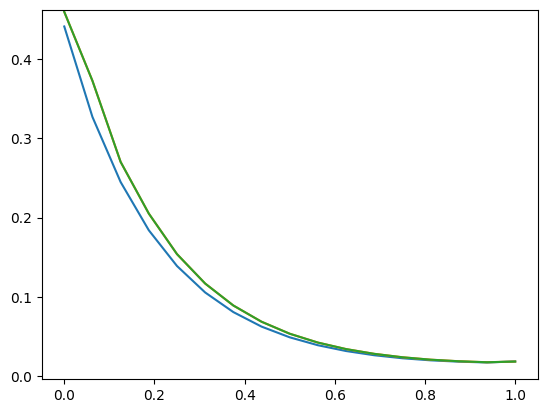

In [ ]:
#dt = 0.01
#T = 1.0
#degree = 1
#x = np.linspace(0,1.0,10)
#cn = Constant(0.0) #Expression("cos(x)", degree=1)
#gamma = Constant(1.0)
#ch_constant_16 = adv_diff(16,degree, dt, cn, gamma)
#plot(ch_constant_16)
#print(ch_constant_16.vector().get_local())

In [12]:
# @title coupler_kdtree.py

import vtk
import meshio

from dolfin import *
from dolfin import sqrt
from vtk.util.numpy_support import vtk_to_numpy
from xii import *
from graphnics import *
from scipy.spatial import cKDTree

def save_mesh_vtk(Lambda, file_path, radius_map_G, uh1d=None):
    """
    Saves a tube mesh as a VThK file with the option to include the 1D solution as a data array.

    Args:
        Lambda (dolfin.Mesh): The mesh to be saved.
        file_path (str): The path where the VTK file will be saved.
        radius_map_G (dolfin.UserExpression): A function to compute radius values at each point.
        uh1d (dolfin.Function, optional): A function representing 1D pressure data.

    Returns:
        None
    """
    points = Lambda.coordinates()
    cells = {"line": Lambda.cells()}

    # Evaluate radius function at each node in the mesh
    radius_values = np.array([radius_map_G(point) for point in points])

    # Evaluate uh1d function at each node in the mesh
    uh1d_values = np.array([uh1d(point) for point in points])

    if uh1d != None:
        mesh = meshio.Mesh(points, cells, point_data={"radius": radius_values, "Pressure1D": uh1d_values})
    else:
        mesh = meshio.Mesh(points, cells, point_data={"radius": radius_values})
    mesh.write(file_path)

    # Convert the mesh to Polydata using VTK
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(file_path)
    reader.Update()

    # Convert unstructured grid to polydata
    geometryFilter = vtk.vtkGeometryFilter()
    geometryFilter.SetInputData(reader.GetOutput())
    geometryFilter.Update()

    polydata = geometryFilter.GetOutput()

    # Write polydata to a new VTK file
    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(file_path)
    writer.SetInputData(polydata)
    writer.Write()

class radius_function(UserExpression):
    """
    A user expression to compute the radius at a given point based on the nearest control point in a graph.

    Args:
        G (graphnics.FenicsGraph): The graph containing control points with radius information.
        mf (dolfin.MeshFunction): A mesh function associated with the graph.
        kdtree (scipy.spatial.cKDTree): A k-d tree for efficient nearest neighbor search in the graph.
        **kwargs: Additional keyword arguments to be passed to the UserExpression constructor.
    """
    def __init__(self, G, mf, kdtree, **kwargs):
        self.G = G
        self.mf = mf
        self.kdtree = kdtree
        super().__init__(**kwargs)

    def eval(self, value, x):
        p = (x[0], x[1], x[2])
        _, nearest_control_point_index = self.kdtree.query(p)
        nearest_control_point = list(self.G.nodes)[nearest_control_point_index]
        value[0] = self.G.nodes[nearest_control_point]['radius']

    def value_shape(self):
        return ()

def run_perfusion_univ(G, directory_path, del_Omega=3.0, perf3=9.6e-2, perf1=1.45e4, kappa=3.09e-5, gamma=1.0, P_infty=1.0e3):
    """
    Runs a perfusion simulation with Robin far field effects everywhere on a given graph, and saves the results for a universal boundary condition.

    Args:
        G (graphnics.FenicsGraph): The graph representing the network.
        directory_path (str): The directory where the results will be saved
        del_Omega (float, optional): Boundary condition value for 3D pressure. Defaults to 3.0
        perf3 (float, optional): 3D perfusion coefficient
        perf1 (float, optional): 1D perfusion coefficient
        kappa (float, optional): Coupling coefficient
        gamma (float, optional): Boundary condition coefficient for 1D pressure
        P_infty (float, optional): Boundary condition value for 1D pressure

    Returns:
        tuple: A tuple containing:
            - output_file_1d (str): The path to the saved 1D pressure VTK file
            - output_file_3d (str): The path to the saved 3D pressure PVD file
            - uh1d (dolfin.Function): The computed 1D pressure function
            - uh3d (dolfin.Function): The computed 3D pressure function
    """
    # Create \Lambda
    G.make_mesh()
    Lambda, mf = G.get_mesh()

    # Reference copy of \Lambda
    H = G.copy()

    # Create \Omega
    Omega = UnitCubeMesh(16, 16, 16)

    # Translate all \Lambda points to positive, same in H
    pos = nx.get_node_attributes(G, "pos")
    node_coords = np.asarray(list(pos.values()))
    xmin, ymin, zmin = np.min(node_coords, axis = 0)
    d = Lambda.coordinates()
    d[:, :] += [-xmin, -ymin, -zmin]
    for node in H.nodes:
        H.nodes[node]['pos'] = np.array(H.nodes[node]['pos']) + [-xmin, -ymin, -zmin]

    # \Lambda k-d tree
    kdtree = cKDTree(np.array(list(nx.get_node_attributes(H, 'pos').values())))

    # Fit \Omega around \Lambda
    c = Omega.coordinates()
    xl, yl, zl = (np.max(node_coords, axis=0)-np.min(node_coords, axis=0))
    c[:,:] *= [xl+3, yl+3, zl]

    def boundary_Omega(x, on_boundary):
        return on_boundary and not near(x[2], 0) and not near(x[2], zl)

    # Constants
    kappa = Constant(kappa)
    gamma = Constant(gamma)
    P_infty = Constant(P_infty)
    del_Omega = Constant(del_Omega)

    # Function spaces
    V3 = FunctionSpace(Omega, "CG", 1)
    V1 = FunctionSpace(Lambda, "CG", 1)
    W = [V3, V1]
    u3, u1 = list(map(TrialFunction, W))
    v3, v1 = list(map(TestFunction, W))

    radius_map_G = radius_function(G, mf, kdtree)
    cylinder = Circle(radius=radius_map_G, degree=5)
   # n = FacetNormal(Lambda)
   # n_normalized = n / sqrt(dot(n, n))

    u3_avg = Average(u3, Lambda, cylinder)#, n=n_normalized)  # Pass n_normalized to Average
    v3_avg = Average(v3, Lambda, cylinder)#, n=n_normalized)

    # Dirac measures
    dxOmega = Measure("dx", domain=Omega)
    dxLambda = Measure("dx", domain=Lambda)
    dsLambda = Measure("ds", domain=Lambda)

    # Define D_area and D_perimeter
    D_area = np.pi * radius_map_G ** 2
    D_perimeter = 2 * np.pi * radius_map_G

    # Blocks
    a00 = perf3 * inner(grad(u3), grad(v3)) * dx + kappa * inner(u3_avg, v3_avg) * D_perimeter * dxLambda
    a01 = -kappa * inner(u1, v3_avg) * D_perimeter * dxLambda
    a10 = -kappa * inner(u3_avg, v1) * D_perimeter * dxLambda
    a11 = perf1 * inner(grad(u1), grad(v1)) * D_area * dxLambda + kappa * inner(u1, v1) * D_perimeter * dxLambda - gamma * inner(u1, v1) * dsLambda

    # Right-hand side
    L0 = inner(Constant(0), v3_avg) * dxLambda
    L1 = -gamma * inner(P_infty, v1) * dsLambda

    a = [[a00, a01], [a10, a11]]
    L = [L0, L1]

    W_bcs = [[DirichletBC(V3, del_Omega, boundary_Omega)], []]

    A, b = map(ii_assemble, (a, L))
    A, b = apply_bc(A, b, W_bcs)
    A, b = map(ii_convert, (A, b))

    wh = ii_Function(W)
    solver = LUSolver(A, "mumps")
    solver.solve(wh.vector(), b)
    uh3d, uh1d = wh
    uh3d.rename("3D Pressure", "3D Pressure Distribution")
    uh1d.rename("1D Pressure", "1D Pressure Distribution")

    # Create output directory if it doesn't exist and save
    os.makedirs(directory_path, exist_ok=True)
    output_file_1d = os.path.join(directory_path, "pressure1d.vtk")
    output_file_3d = os.path.join(directory_path, "pressure3d.pvd")
    save_mesh_vtk(Lambda, output_file_1d, radius_map_G, uh1d=uh1d)
    File(output_file_3d) << uh3d

    return output_file_1d, output_file_3d, uh1d, uh3d, Lambda, Omega


def run_perfusion_univ_time(G, directory_path, del_Omega=3.0, perf3=9.6e-2, perf1=1.45e4, kappa=3.09e-5, gamma=1.0, P_infty=1.0e3, dt=0.1, num_steps=20):
    """
    Runs a time-dependent perfusion simulation using the backward Euler method.

    Args:
        G (graphnics.FenicsGraph): The graph representing the network.
        directory_path (str): The directory where the results will be saved
        del_Omega (float, optional): Boundary condition value for 3D pressure. Defaults to 3.0
        perf3 (float, optional): 3D perfusion coefficient
        perf1 (float, optional): 1D perfusion coefficient
        kappa (float, optional): Coupling coefficient
        gamma (float, optional): Boundary condition coefficient for 1D pressure
        P_infty (float, optional): Boundary condition value for 1D pressure
        dt (float, optional): Time step size
        num_steps (int, optional): Number of time steps to run the simulation

    Returns:
        tuple: A tuple containing:
            - output_file_1d (str): The path to the saved 1D pressure VTK file
            - output_file_3d (str): The path to the saved 3D pressure PVD file
            - uh1d (dolfin.Function): The computed 1D pressure function
            - uh3d (dolfin.Function): The computed 3D pressure function
    """
    # Create \Lambda
    G.make_mesh()
    Lambda, mf = G.get_mesh()

    # Reference copy of \Lambda
    H = G.copy()

    # Create \Omega
    Omega = UnitCubeMesh(32, 32, 32)

    # Translate all \Lambda points to positive, same in H
    pos = nx.get_node_attributes(G, "pos")
    node_coords = np.asarray(list(pos.values()))
    xmin, ymin, zmin = np.min(node_coords, axis = 0)
    d = Lambda.coordinates()
    d[:, :] += [-xmin, -ymin, -zmin]
    for node in H.nodes:
        H.nodes[node]['pos'] = np.array(H.nodes[node]['pos']) + [-xmin, -ymin, -zmin]

    # \Lambda k-d tree
    kdtree = cKDTree(np.array(list(nx.get_node_attributes(H, 'pos').values())))

    # Fit \Omega around \Lambda
    c = Omega.coordinates()
    xl, yl, zl = (np.max(node_coords, axis=0)-np.min(node_coords, axis=0))
    c[:,:] *= [xl+3, yl+3, zl]

    def boundary_Omega(x, on_boundary):
        return on_boundary and not near(x[2], 0) and not near(x[2], zl)

    # Constants
    kappa = Constant(kappa)
    gamma = Constant(gamma)
    P_infty = Constant(P_infty)
    del_Omega = Constant(del_Omega)
    dt = Constant(dt)
    perf3 = Constant(perf3)
    perf1 = Constant(perf1)

    # Function spaces
    V3 = FunctionSpace(Omega, "CG", 1)
    V1 = FunctionSpace(Lambda, "CG", 1)
    W = [V3, V1]
    u3, u1 = list(map(TrialFunction, W))
    v3, v1 = list(map(TestFunction, W))

    _, _, u1_n, u3_n, _, _ = run_perfusion_univ(G, os.path.join(directory_path, "ignore"), del_Omega=3.0, perf3=9.6e-2, perf1=1.45e4, kappa=3.09e-5, gamma=1.0, P_infty=1.0e3)

    radius_map_G = radius_function(G, mf, kdtree)
    cylinder = Circle(radius=radius_map_G, degree=5)

    # Normalize the normal vector before passing it to Average
    # n = FacetNormal(Lambda)
   # n_normalized = n / sqrt(dot(n, n))

    u3_avg = Average(u3, Lambda, cylinder)#, n=n_normalized)  # Pass n_normalized to Average
    v3_avg = Average(v3, Lambda, cylinder)#, n=n_normalized)

    # Dirac measures
    dxOmega = Measure("dx", domain=Omega)
    dxLambda = Measure("dx", domain=Lambda)
    dsLambda = Measure("ds", domain=Lambda)

    # Define D_area and D_perimeter
    D_area = np.pi * radius_map_G ** 2
    D_perimeter = 2 * np.pi * radius_map_G

    # Create output directory if it doesn't exist
    os.makedirs(directory_path, exist_ok=True)
    output_file_1d = os.path.join(directory_path, "pressure1d")
    output_file_3d = os.path.join(directory_path, "pressure3d")

    # Create master .pvd files for animation
    pvd_1d = File(f"{output_file_1d}.pvd")
    pvd_3d = File(f"{output_file_3d}.pvd")

    # Time-stepping
    for n in range(num_steps):
        current_time = n * float(dt)

        # Variational forms
        a00 = (1/dt) * inner(u3, v3) * dxOmega + perf3 * inner(grad(u3), grad(v3)) * dxOmega + kappa * inner(u3_avg, v3_avg) * D_perimeter * dxLambda
        a01 = -kappa * inner(u1, v3_avg) * D_perimeter * dxLambda
        a10 = -kappa * inner(u3_avg, v1) * D_perimeter * dxLambda
        #a11 = inner(adv_diff(16, 1, dt, 0.0, gamma), v1) * dxLambda
        #a11 = adv_diff(16, 1, dt, 0.0, gamma)
        adv_diff_sol = adv_diff(16, 1, dt, 0.0, gamma)
        a11 = perf1 * inner(grad(u1), grad(v1)) * D_area * dxLambda + kappa * inner(u1, v1) * D_perimeter * dxLambda - gamma * inner(u1, v1) * dsLambda + inner(adv_diff_sol, v1) * dxLambda # integrate the result into a11


        # Right-hand side
        L0 = (1/dt) * inner(u3_n, v3) * dxOmega + inner(Constant(0), v3_avg) * dxOmega
        L1 = D_area * (1/dt) * inner(u1_n, v1) * dxLambda + inner(Constant(0), v1) * dxLambda - gamma * inner(P_infty, v1) * dsLambda

        a = [[a00, a01], [a10, a11]]
        L = [L0, L1]

        W_bcs = [[DirichletBC(V3, del_Omega, boundary_Omega)], []]

        A, b = map(ii_assemble, (a, L))
        A, b = apply_bc(A, b, W_bcs)
        A, b = map(ii_convert, (A, b))

        wh = ii_Function(W)
        solver = LUSolver(A, "mumps")
        solver.solve(wh.vector(), b)
        uh3d, uh1d = wh
        uh3d.rename("3D Pressure", "3D Pressure Distribution")
        uh1d.rename("1D Pressure", "1D Pressure Distribution")

        # Save to .pvd
        pvd_3d << (uh3d, n)
        pvd_1d << (uh1d, n)

        # Update previous solution
        u3_n.assign(uh3d)
        u1_n.assign(uh1d)

    return f"{output_file_1d}.pvd", f"{output_file_3d}.pvd"


Averaging over 146 cells: 100%|██████████| 146/146 [00:00<00:00, 929.62it/s]


[1.55235304 1.58261567 1.43928982 1.46368828 1.33695313 1.35894301
 1.24484817 1.26461337 1.16225388 1.17994896 1.0885278  1.10428991
 1.02310226 1.03705219 0.96548003 0.97772315 0.91523072 0.92585774
 0.87198768 0.88107527 0.83544543 0.84305677 0.80535776 0.8115429
 0.78153621 0.78633238 0.76384933 0.76728095 0.75225452 0.75429738
 0.75640567 0.74630847]


Averaging over 146 cells: 100%|██████████| 146/146 [00:00<00:00, 911.13it/s]


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_07fbb3bb64b09be2162ace1d1d7c09d154e9951d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.


ArityMismatch: Adding expressions with non-matching form arguments ('v_0', 'v_1') vs ('v_0',).

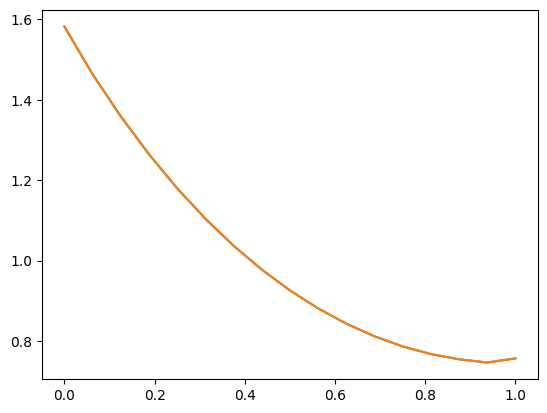

In [13]:
CST_TIME = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=-5))).strftime("%Y-%m-%d_%H-%M")
OUTPUT_PATH = os.path.join(WD_PATH, f'univ_test_{CST_TIME}')

# This will store uh1d, uh3d, Lambda, and Omega in RAM
output_file_1d, output_file_3d, uh1d, uh3d, Lambda, Omega = run_perfusion_univ_time(G, OUTPUT_PATH,
    del_Omega=3.0,
    perf3=9.6e-2,
    perf1=1.45e4,
    kappa=3.09e-5,
    gamma=1.0,
    P_infty=1.0e3
)

In [ ]:
# @title visualizer.py
import matplotlib
import matplotlib.pyplot as plt
import numpy
import plotly
import scipy
import plotly.graph_objects as go
import numpy as np
import scipy.interpolate

def visualize(mesh1d, uh1d, mesh3d=None, uh3d=None, z_level=50, elev=10, azim=30, boundary_list=None):
    node_coords = mesh1d.coordinates()
    pressure_values = uh1d.compute_vertex_values(mesh1d)

    x_min, x_max = node_coords[:, 0].min(), node_coords[:, 0].max()
    y_min, y_max = node_coords[:, 1].min(), node_coords[:, 1].max()
    x_width, y_width = x_max - x_min, y_max - y_min

    num_columns = 2 if (uh3d is not None and mesh3d is not None) else 1
    fig, ax1 = plt.subplots(1, num_columns, figsize=(20, 8) if num_columns == 2 else (10, 8))
    ax1 = fig.add_subplot(121, projection='3d')

    if num_columns == 2:
        pressure_3d_values = uh3d.compute_vertex_values(mesh3d)
        coords_3d = mesh3d.coordinates()

        z_coords = coords_3d[:, 2]
        mask = np.isclose(z_coords, z_level, atol=mesh3d.hmin())
        filtered_coords = coords_3d[mask]
        filtered_pressure = pressure_3d_values[mask]

        # grid for the heatmap
        x = filtered_coords[:, 0]
        y = filtered_coords[:, 1]
        z = filtered_pressure
        grid_size = 200
        xi = np.linspace(x.min(), x.max(), grid_size)
        yi = np.linspace(y.min(), y.max(), grid_size)
        zi = scipy.interpolate.griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')

        fig.get_axes()[0].axis('off')
        fig.get_axes()[1].axis('off')
    else:
        fig.get_axes()[0].axis('off')

    # (1D) 2D plane at Z = z_level
    x_plane, y_plane = np.meshgrid(
        np.linspace(x_min, x_max, num=10),
        np.linspace(y_min, y_max, num=10)
    )
    z_plane = np.full(x_plane.shape, z_level)

    ax1.plot_surface(x_plane, y_plane, z_plane, color='m', alpha=0.3, zorder=10) # ensure plane is in front
    ax1.view_init(elev=elev, azim=azim)
    sc = ax1.scatter(node_coords[:, 0], node_coords[:, 1], node_coords[:, 2], c=pressure_values, cmap='viridis', s=0.1)
    cbar = plt.colorbar(sc, ax=ax1)
    cbar.set_label('1D Pressure')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('1D Domain')

    if boundary_list is not None:
        for point in boundary_list:
            ax1.scatter(*point, color='red')

    # (3D) 2D heatmap subplot
    if num_columns == 2:
        ax2 = fig.add_subplot(122)
        cf = ax2.contourf(xi, yi, zi, levels=100, cmap='viridis')
        cbar = plt.colorbar(cf, ax=ax2)
        cbar.set_label('Pressure')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_title(f'3D Domain Section at Z = {z_level}')

    plt.gca().set_aspect('equal')
    plt.show()

def visualize_scatter(mesh1d, uh1d, z_level=50, boundary_list=None):
    node_coords = mesh1d.coordinates()
    pressure_values = uh1d.compute_vertex_values(mesh1d)

    fig = go.Figure()

    fig.add_trace(go.Scatter3d(x=node_coords[:, 0], y=node_coords[:, 1], z=node_coords[:, 2],
                              mode='markers',
                              marker=dict(size=2, color=pressure_values, colorscale='Viridis', colorbar=dict(title='1D Pressure')), hovertext=[f"Pressure: {val:.4f}" for val in pressure_values],
                              name=''))

    # Plane at Z = z_level
    x_min, x_max, y_min, y_max = node_coords[:, 0].min(), node_coords[:, 0].max(), node_coords[:, 1].min(), node_coords[:, 1].max()
    x_plane, y_plane = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))
    z_plane = z_level * np.ones_like(x_plane)

    fig.add_trace(go.Surface(x=x_plane, y=y_plane, z=z_plane, opacity=0.3, name=f'Plane at Z={z_level}'))

    # Boundary points
    if boundary_list:
        fig.add_traces([go.Scatter3d(x=[p[0]], y=[p[1]], z=[p[2]], showlegend = False, mode='markers', marker=dict(size=5, color='red')) for p in boundary_list])

    # Set camera view
    fig.update_layout(
        scene_camera=dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0), eye=dict(x=-1.25, y=-1.25, z=1.25)),
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        width=1000, height=800
    )

    fig.show()

def visualize_contour(mesh3d, uh3d, z_level=50):
    if uh3d is not None and mesh3d is not None:
        pressure_3d_values = uh3d.compute_vertex_values(mesh3d)
        coords_3d = mesh3d.coordinates()

        z_coords = coords_3d[:, 2]
        mask = np.isclose(z_coords, z_level, atol=mesh3d.hmin())
        filtered_coords = coords_3d[mask]
        filtered_pressure = pressure_3d_values[mask]

        x = filtered_coords[:, 0]
        y = filtered_coords[:, 1]
        z = filtered_pressure
        grid_size = 200
        xi = np.linspace(x.min(), x.max(), grid_size)
        yi = np.linspace(y.min(), y.max(), grid_size)
        zi = scipy.interpolate.griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')

        fig = go.Figure()
        fig.add_trace(go.Contour(
            z=zi,
            x=xi,
            y=yi,
            colorscale='Viridis',
            colorbar=dict(title='Pressure'),
            name=f'3D Domain Section at Z = {z_level}'
        ))

        fig.update_layout(
            xaxis = dict(title='X'),
            yaxis = dict(title='Y', scaleanchor="x", scaleratio=1),
            width=800,
            height=800
        )

        fig.show()

In [ ]:
visualize_scatter(Lambda, uh1d)

NameError: name 'Lambda' is not defined